In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import copy

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=8, width=1.5, direction='in')
        ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=8, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
####################################### Plotting Function

In [3]:
calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
                21102, 22277, 26761, 28378, 29128, 38148, 41020, 
                41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]

W1_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588, 
             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814, 
             14548, 14590]

table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

108


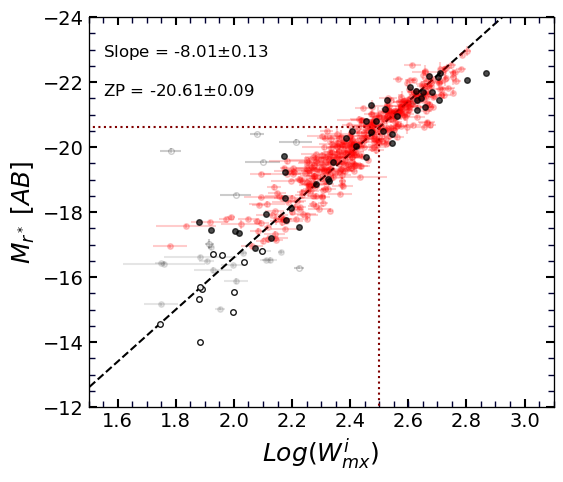

In [4]:
band = 'r'

fig, ax, Clusters, S_ZP = makeTF(table, pgcFaint=W1_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True)

In [5]:
slope = S_ZP[0]
zp    = S_ZP[2]

zp_calibs = all_ZP(table, band=band, slope=slope, pgcFaint=calib_maglim)

# fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)

key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo  = myCluster['zp']

MAG       = myCluster['mag']-zp_virgo+zp
MAG_w     = myCluster['mag_w']-zp_virgo+zp
logWimx   = myCluster['logWimx']
logWimx_w = myCluster['logWimx_w']
pgc       = myCluster['pgc']
pgc_w     = myCluster['pgc_w']

for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        
        MAG       = np.concatenate((MAG, myCluster['mag']-zp_+zp))
        MAG_w     = np.concatenate((MAG_w, myCluster['mag_w']-zp_+zp))
        logWimx   = np.concatenate((logWimx, myCluster['logWimx']))
        logWimx_w = np.concatenate((logWimx_w, myCluster['logWimx_w']))
        pgc       =  np.concatenate((pgc, myCluster['pgc']))
        pgc_w     =  np.concatenate((pgc, myCluster['pgc_w']))


indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in W1_maglim:
        indx.append(i)
    else:
        indx_.append(i) # faint

        
MAG_faint       = []
logWimx_faint   = []
pgc_faint       = []

if len(indx_)>0:
    MAG_faint       = MAG[indx_]
    logWimx_faint   = logWimx[indx_]
    pgc_faint       = pgc[indx_]

if len(indx)>0:
    MAG       = MAG[indx]
    logWimx   = logWimx[indx]
    pgc       = pgc[indx]


108


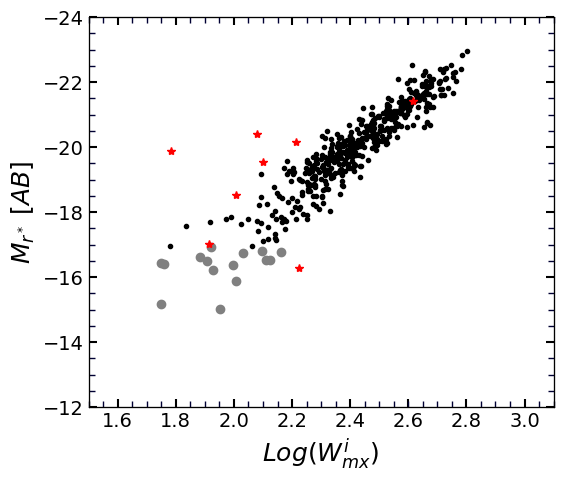

In [6]:
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)
ax.plot(logWimx, MAG, '.', color='k')
ax.plot(logWimx_faint, MAG_faint, 'o', color='gray')
ax.plot(logWimx_w, MAG_w, '*', color='red')

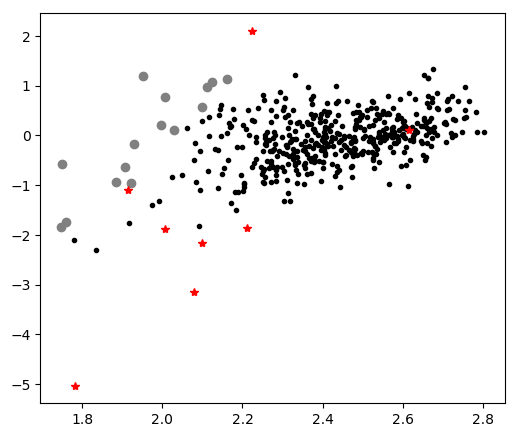

In [7]:
delta = MAG - (slope*(logWimx-2.5)+zp)
delta_faint = MAG_faint - (slope*(logWimx_faint-2.5)+zp)
delta_w = MAG_w - (slope*(logWimx_w-2.5)+zp)

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)
# ax.set_xlim(xLim)        
# ax.set_ylim(yLim)

ax.plot(logWimx, delta, '.', color='black')
ax.plot(logWimx_faint, delta_faint, 'o', color='gray')
ax.plot(logWimx_w, delta_w, '*', color='red')

In [8]:
catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']


N = len(pgc)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

for i, idd in enumerate(pgc):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]
    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
mu50_w1 = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2 = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in subtract


In [9]:
delta = MAG - (slope*(logWimx-2.5)+zp)


g_i   = ggg-iii
i_w1  = iii-w11
r_w1  = rrr-w11
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz 
r_z   = rrr-zzz 
m21_g = m21-ggg
m21_r = m21-rrr 
m21_i = m21-iii
m21_z = m21-zzz 
m21_w = m21-w11

indx, = np.where(iii>5)
delta = delta[indx]
logWimx_ = logWimx[indx]
iii   = iii[indx]
w11   = w11[indx]
g_i   = g_i[indx]
i_w1  = i_w1[indx]
r_w1  = r_w1[indx]
r_i   = r_i[indx]
g_z   = g_z[indx]
r_z   = r_z[indx]
i_z   = i_z[indx]
m21_g = m21_g[indx]
m21_r = m21_r[indx]
m21_i = m21_i[indx]
m21_z = m21_z[indx]
m21_w = m21_w[indx]
mu50_u  = mu50_u[indx]
mu50_g  = mu50_g[indx]
mu50_r  = mu50_r[indx]
mu50_i  = mu50_i[indx]
mu50_z  = mu50_z[indx]
mu50_w1 = mu50_w1[indx]
mu50_w2 = mu50_w2[indx]

indx, = np.where(w11>5)
delta = delta[indx]
logWimx_ = logWimx_[indx]
iii   = iii[indx]
w11   = w11[indx]
g_i   = g_i[indx]
r_w1  = r_w1[indx]
i_w1  = i_w1[indx]
r_i   = r_i[indx]
g_z   = g_z[indx]
r_z   = r_z[indx]
i_z   = i_z[indx]
m21_g = m21_g[indx]
m21_r = m21_r[indx]
m21_i = m21_i[indx]
m21_z = m21_z[indx]
m21_w = m21_w[indx]
mu50_u  = mu50_u[indx]
mu50_g  = mu50_g[indx]
mu50_r  = mu50_r[indx]
mu50_i  = mu50_i[indx]
mu50_z  = mu50_z[indx]
mu50_w1 = mu50_w1[indx]
mu50_w2 = mu50_w2[indx]

In [10]:
def Plot_D_mu(ax, X, Y, xlim=None, ylim=[2.5,-3], x_text='', xlabel=False, ylabel=False, rangeLim=None):
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    
    indx = np.where(X>-10000)
    X = X[indx]
    Y = Y[indx]
    
    if rangeLim is None:
        rangeLim = [-1000,1000]
        
    X_fit = []
    Y_fit = []
    for i, yy in enumerate(Y):
        if yy<1.5 and yy>-1.5 and X[i]<rangeLim[1] and X[i]>rangeLim[0]:
            ax.plot(X[i], yy, '+', color='black')
            X_fit.append(X[i])
            Y_fit.append(yy)
        else:
            ax.plot(X[i], yy, 'o', color='black', markerfacecolor='white')
    
    X_fit = np.asarray(X_fit)
    Y_fit = np.asarray(Y_fit)
    
    ####################################################
    if rangeLim[1] != 1000:
        ll = np.max([rangeLim[0],np.min(X_fit)])
        uu = np.min([rangeLim[1],np.max(X_fit)])
    else: 
        ll = np.min(X_fit)
        uu = np.max(X_fit)
    dd = (uu-ll)/5.
    
    for i in np.arange(ll,uu,dd):
        xp = []
        yp = []
        for ii in range(len(X_fit)):
            xi = X_fit[ii]
            if xi>=i and xi<i+dd:
                xp.append(xi)
                yp.append(Y_fit[ii])
        if len(xp)>0:
            ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color='red', alpha=1.0)     
    ####################################################
    
    if xlim is None:
        # ax.set_ylim([-2.5,2])
        Xlm = ax.get_xlim()
        set_axes([ax], Xlm, ylim)
    else:
        set_axes([ax], xlim, ylim)

    fit, cov = curve_fit(linfit, X_fit, Y_fit)
    m, b = fit
    x = np.linspace(np.min(X),np.max(X), 100)
    y = m*x+b
    ax.plot(x, y, 'g-', linewidth=2)
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]

    dy = np.sqrt(x**2*me**2+be**2+2*x*mbe)
    ax.fill_between(x, y+2*dy, y-2*dy, color='r', alpha=0.3)

    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()


    x0 = 0.97*Xlm[0]+0.03*Xlm[1]
    y0 = 0.07*Ylm[0]+0.93*Ylm[1]
    ax.text(x0,y0, "Slope = "+"%.2f" % m+'$\pm$'+"%.2f" % me, fontsize=16, color='k')
    y0 = 0.15*Ylm[0]+0.85*Ylm[1]
    ax.text(x0,y0, "ZP = "+"%.2f" % b+'$\pm$'+"%.2f" % be, fontsize=16, color='k')

    data = {'X':X_fit, 'Y':Y_fit}
    d = pd.DataFrame.from_dict(data)
    corr = d.corr()
    y0 = 0.23*Ylm[0]+0.77*Ylm[1]
    ax.text(x0,y0, r'$Corr.=$'+'%.2f'%corr['X']['Y'], fontsize=16, color='red')

    if xlabel:
        ax.set_xlabel(x_text, fontsize=20, labelpad=7)
    if ylabel:
        band_label = band
        if band=='w1' or band=='w2':
            band_label = band.upper()
        ax.set_ylabel(band_label+r'$^*-$'+' Mean Correalation', fontsize=20, labelpad=7)

    x0 = 0.65*Xlm[0]+0.35*Xlm[1]
    y0 = 0.95*Ylm[0]+0.05*Ylm[1]
    ax.text(x0,y0, "RMS = "+"%.2f" % np.sqrt(np.median(Y_fit**2))+' mag', fontsize=16, color=dye[band])
#     ax.text(x0,y0, "RMS = "+"%.2f" % np.std(Y_fit**2)+' mag', fontsize=16, color=dye[band])
    
    Delta_new = Y_fit - (m*X_fit+b)
    x0 = 0.27*Xlm[0]+0.73*Xlm[1]
    ax.text(x0,y0, "-> "+"%.2f" % np.sqrt(np.median(Delta_new**2)), fontsize=16, color='k') 
#     ax.text(x0,y0, "-> "+"%.2f" % np.std(Delta_new), fontsize=16, color='k') 
    

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

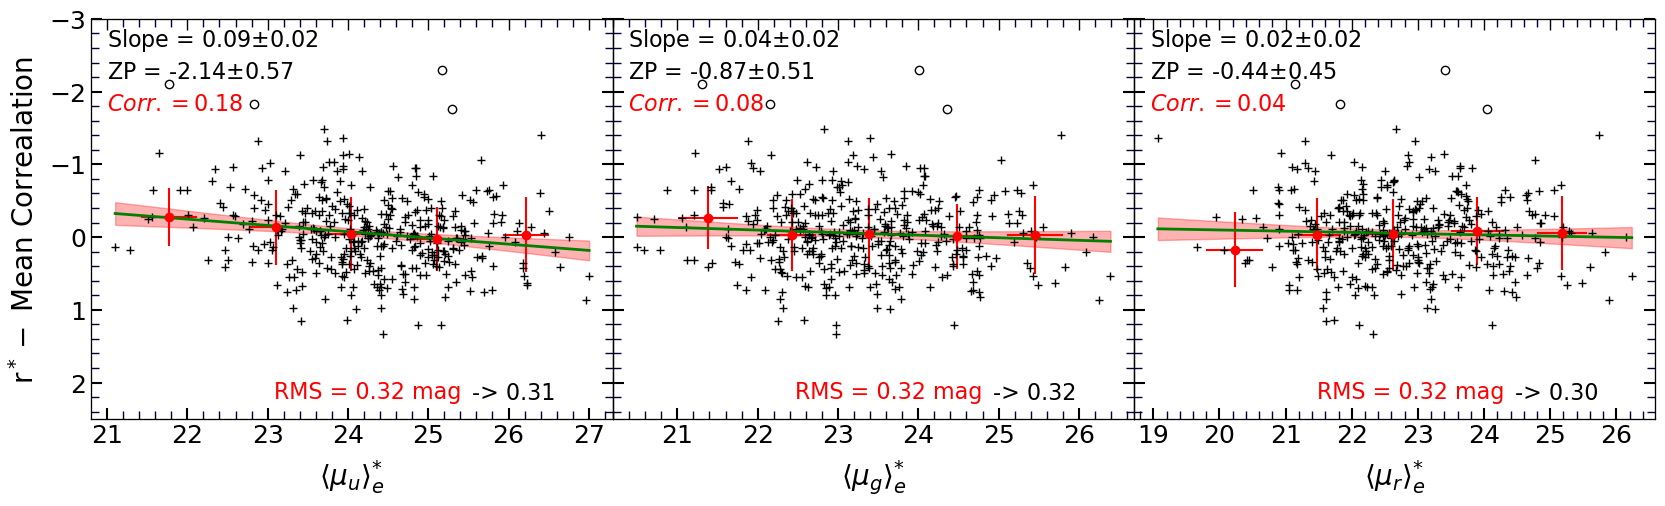

In [11]:
fig = py.figure(figsize=(17, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])


Plot_D_mu(ax1, mu50_u, delta, x_text=r'$\langle \mu_u \rangle^{*}_e$', xlabel=True, ylabel=True)
Plot_D_mu(ax2, mu50_g, delta, x_text=r'$\langle \mu_g \rangle^{*}_e$', xlabel=True)
Plot_D_mu(ax3, mu50_r, delta, x_text=r'$\langle \mu_r \rangle^{*}_e$', xlabel=True)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

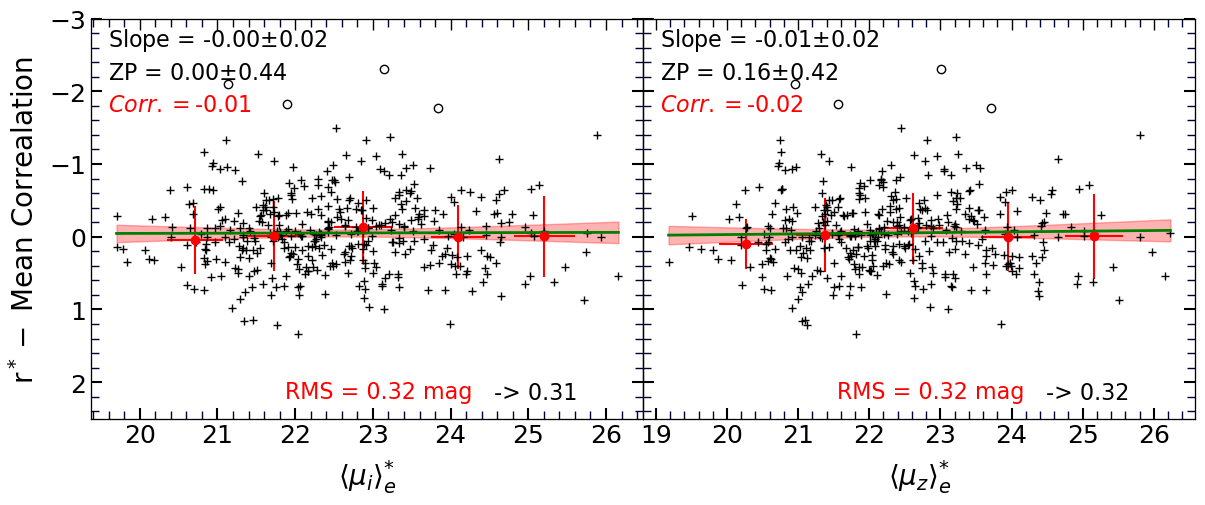

In [12]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


Plot_D_mu(ax1, mu50_i, delta, x_text=r'$\langle \mu_i \rangle^{*}_e$', xlabel=True, ylabel=True)
Plot_D_mu(ax2, mu50_z, delta, x_text=r'$\langle \mu_z \rangle^{*}_e$', xlabel=True)

plt.setp(ax2.get_yticklabels(), visible=False)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

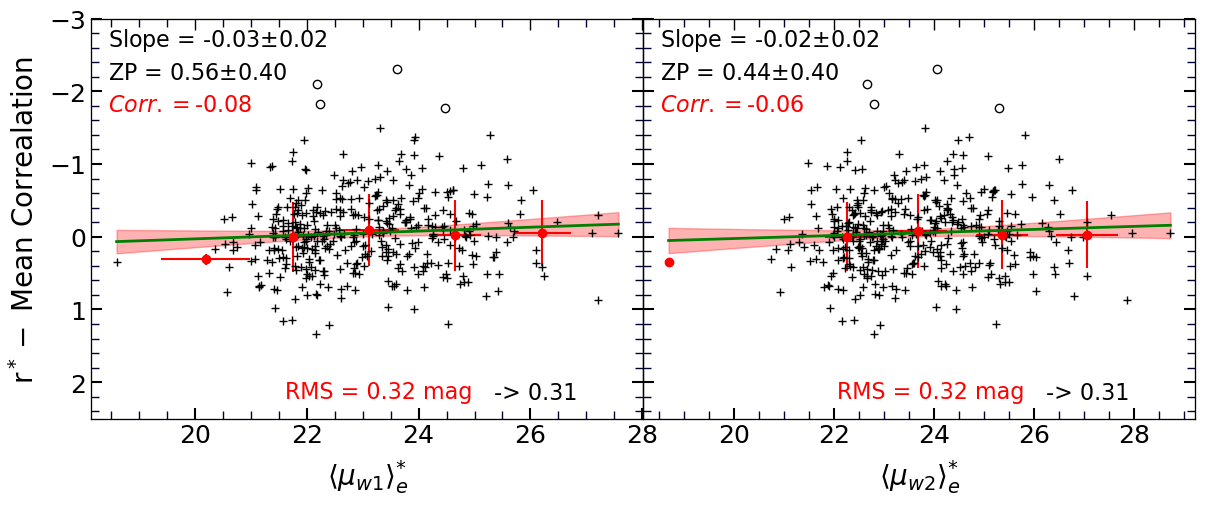

In [13]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


Plot_D_mu(ax1, mu50_w1, delta, x_text=r'$\langle \mu_{w1} \rangle^{*}_e$', xlabel=True, ylabel=True)
Plot_D_mu(ax2, mu50_w2, delta, x_text=r'$\langle \mu_{w2} \rangle^{*}_e$', xlabel=True)

plt.setp(ax2.get_yticklabels(), visible=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

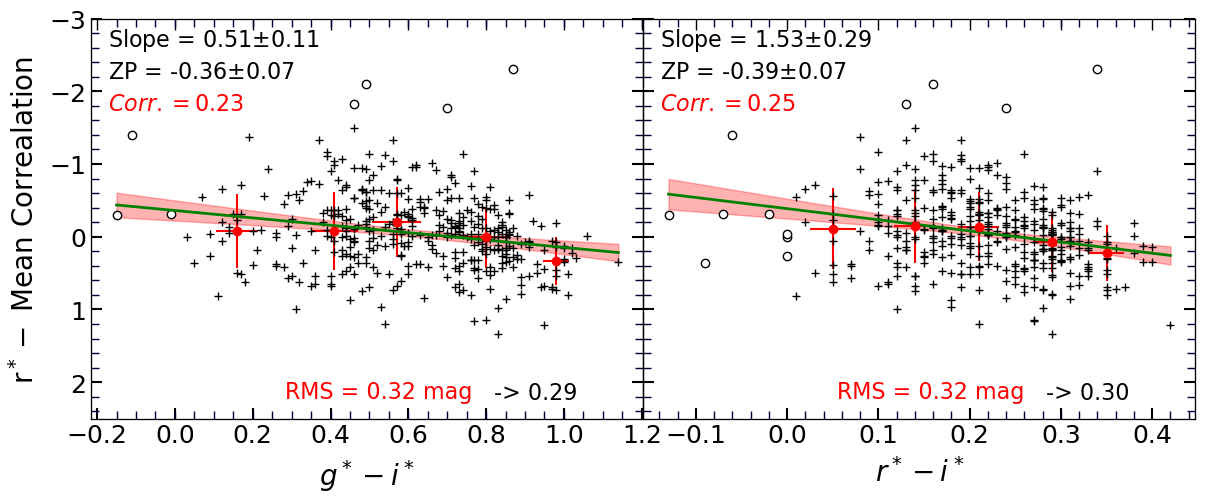

In [14]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


Plot_D_mu(ax1, g_i, delta, x_text=r'$g^*-i^*$', xlabel=True, ylabel=True, rangeLim=[0,100])
Plot_D_mu(ax2, r_i, delta, x_text=r'$r^*-i^*$', xlabel=True, rangeLim=[0,100])

plt.setp(ax2.get_yticklabels(), visible=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

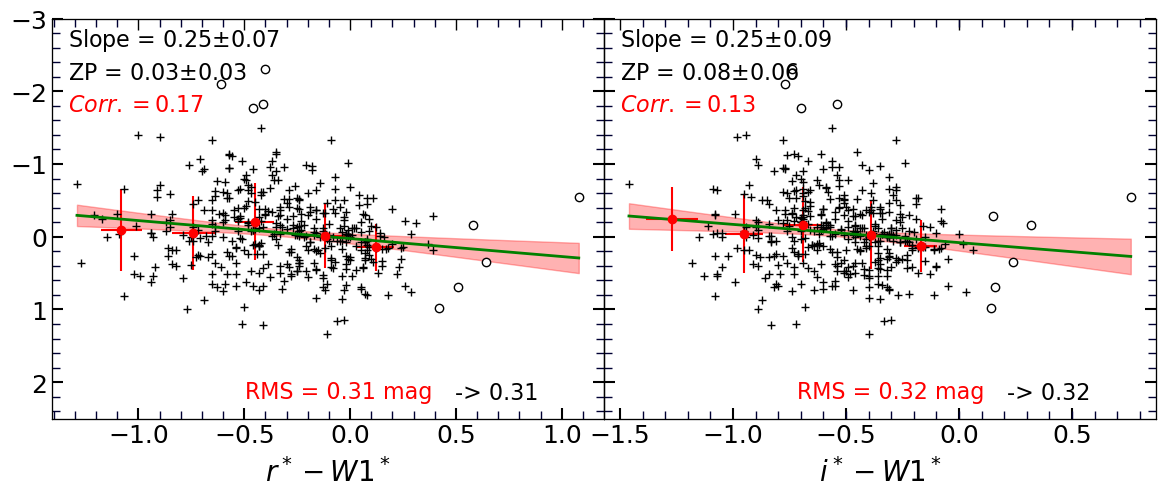

In [15]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


Plot_D_mu(ax1, r_w1, delta, x_text=r'$r^*-W1^*$', xlabel=True, rangeLim=[-100,0.4])
Plot_D_mu(ax2, i_w1, delta, x_text=r'$i^*-W1^*$', xlabel=True, rangeLim=[-100,0.1])

plt.setp(ax2.get_yticklabels(), visible=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

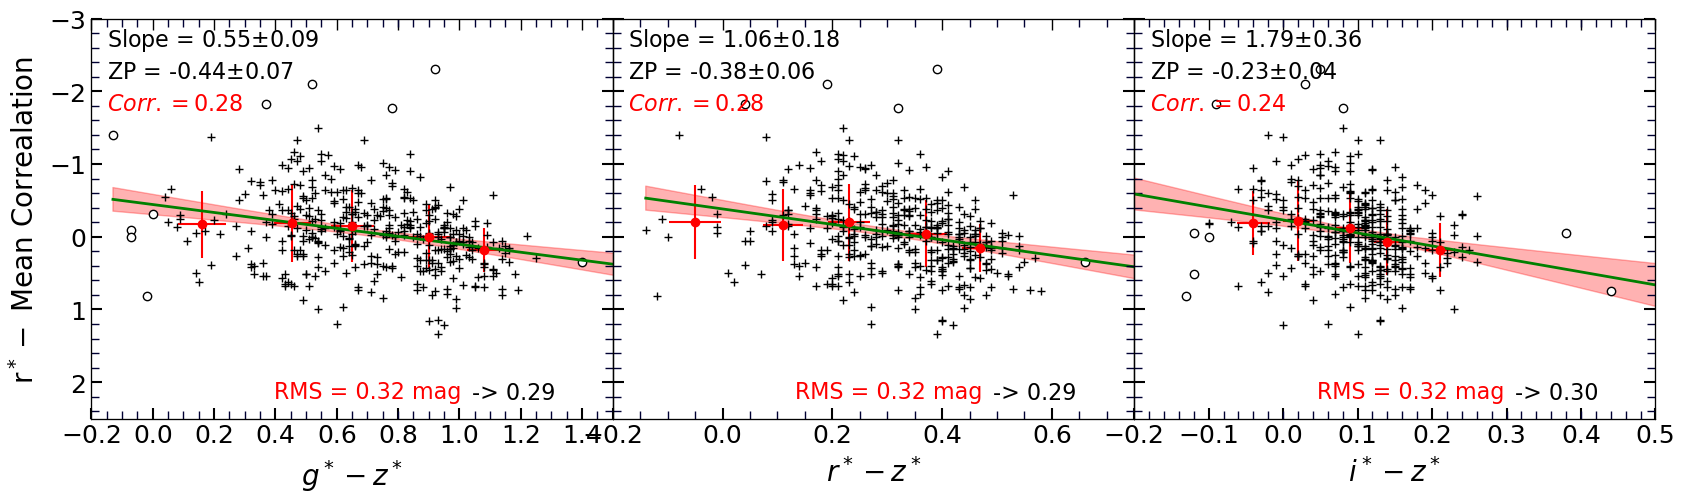

In [16]:
fig = py.figure(figsize=(17, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])


Plot_D_mu(ax1, g_z, delta, x_text=r'$g^*-z^*$', xlabel=True, ylabel=True, xlim=[-0.2,1.5], rangeLim=[0,1.3])
Plot_D_mu(ax2, r_z, delta, x_text=r'$r^*-z^*$', xlabel=True, xlim=[-0.2,0.75], rangeLim=[-0.5,0.65])
Plot_D_mu(ax3, i_z, delta, x_text=r'$i^*-z^*$', xlabel=True, xlim=[-0.2,0.5], rangeLim=[-0.1,0.3])

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

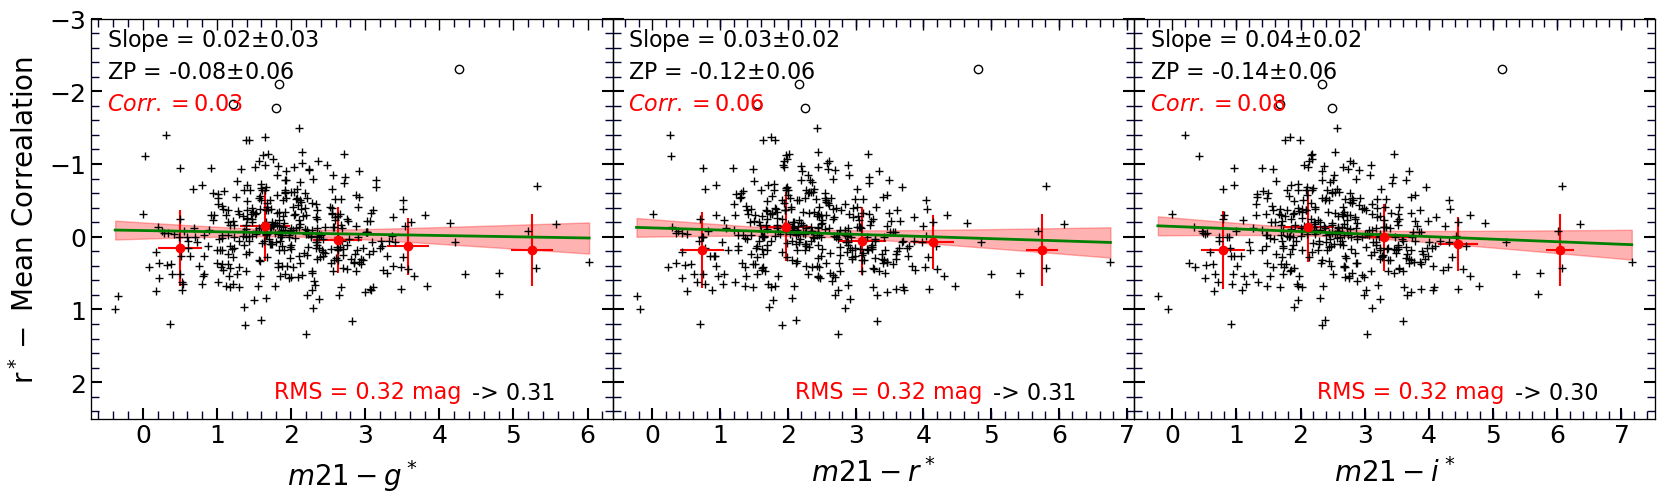

In [17]:
fig = py.figure(figsize=(17, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])


Plot_D_mu(ax1, m21_g, delta, x_text=r'$m21-g^*$', xlabel=True, ylabel=True)
Plot_D_mu(ax2, m21_r, delta, x_text=r'$m21-r^*$', xlabel=True)
Plot_D_mu(ax3, m21_i, delta, x_text=r'$m21-i^*$', xlabel=True)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

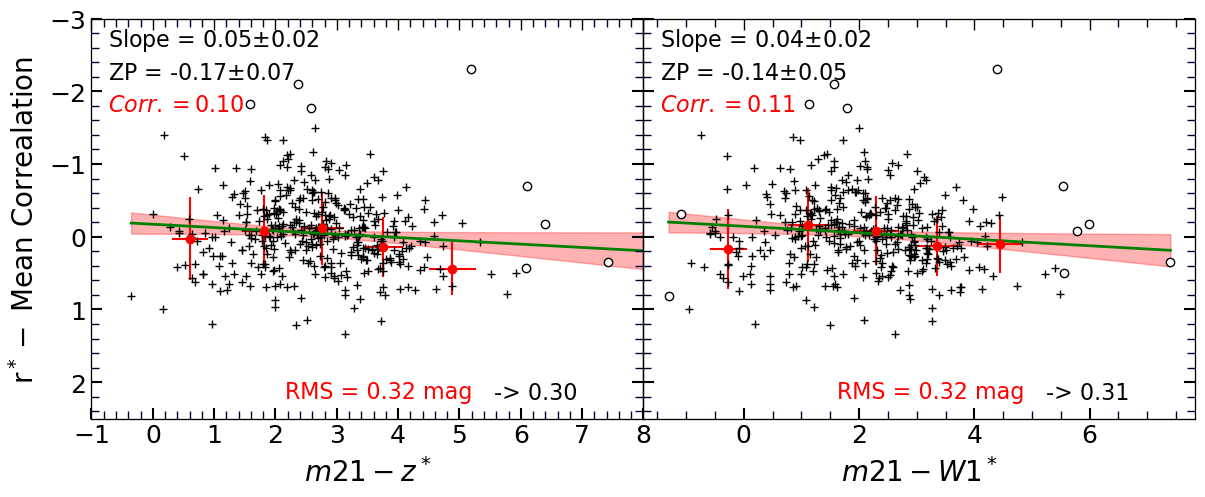

In [18]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

Plot_D_mu(ax1, m21_z, delta, x_text=r'$m21-z^*$', xlabel=True, ylabel=True, xlim=[-1,8], rangeLim=[-1,6])
Plot_D_mu(ax2, m21_w, delta, x_text=r'$m21-W1^*$', xlabel=True, rangeLim=[-1,5.5])

plt.setp(ax2.get_yticklabels(), visible=False)